<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/F_principle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install tf-nightly-2.0-preview

     |████████████████████████████████| 87.3MB 62.0MB/s 
     |████████████████████████████████| 61kB 24.8MB/s 
     |████████████████████████████████| 430kB 52.0MB/s 
     |████████████████████████████████| 3.1MB 44.7MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [2]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.math import sin
import time
%matplotlib inline
from scipy.fftpack import fft, fftfreq, fftshift
import scipy
from scipy.fftpack import fft
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190504


In [3]:
def f(x):
    return sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)

def psy_trial(x, net_out):
    return (-1. - x) * (1. - x) * net_out
  
model = Sequential()
model.add(Dense(128, input_shape=(None, 1), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(0.0005)

nx = 100
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)

batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(x_space).batch(batch_size, drop_remainder=True)

example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (16, 1)


# Train

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)
  
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        
        func = f(x) # right part function
        loss = loss_function(-d2y_dx2, func)
#         print(d2y_dx2)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

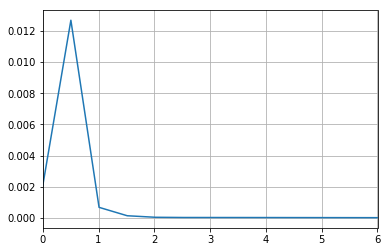

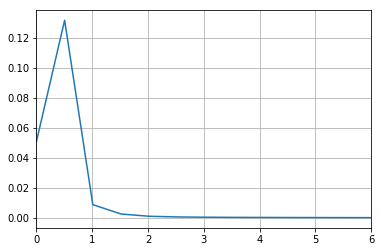

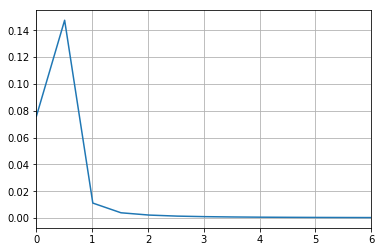

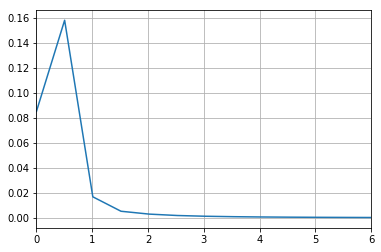

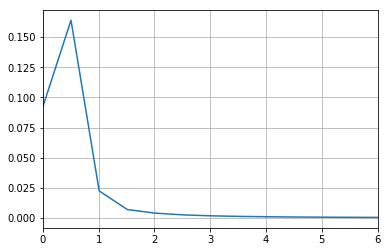

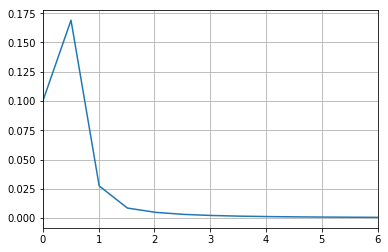

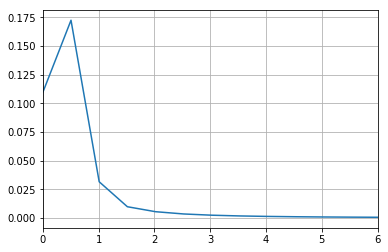

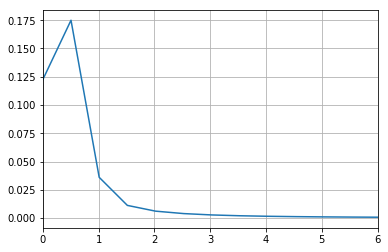

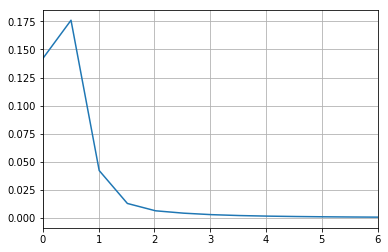

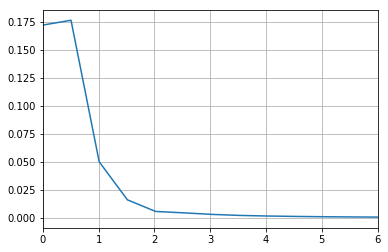

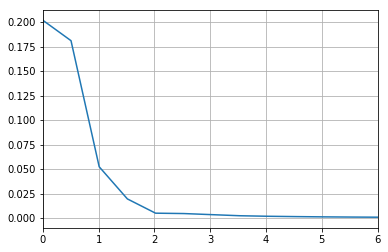

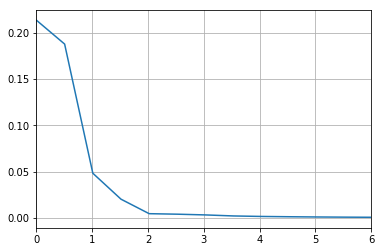

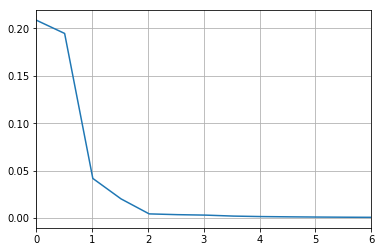

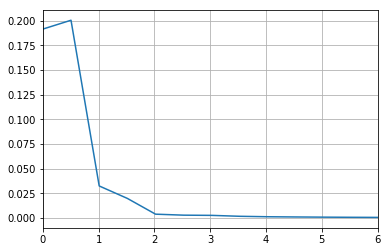

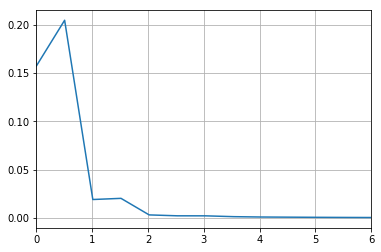

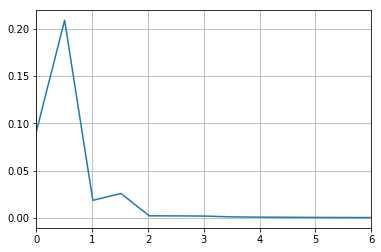

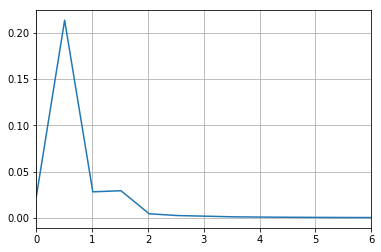

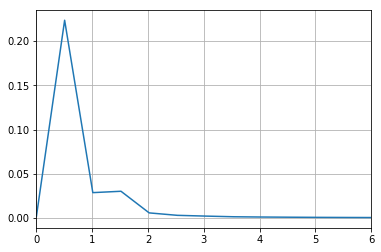

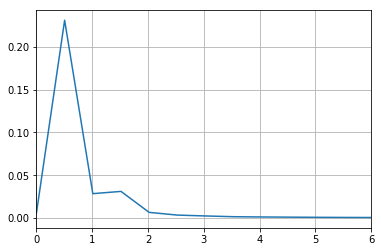

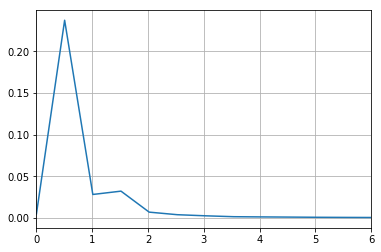

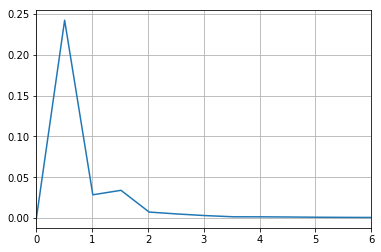

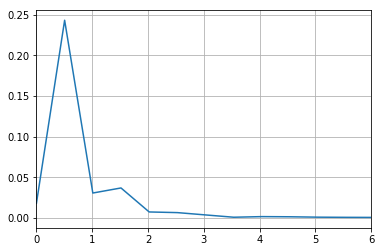

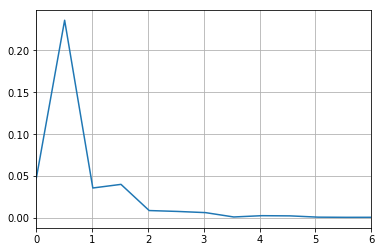

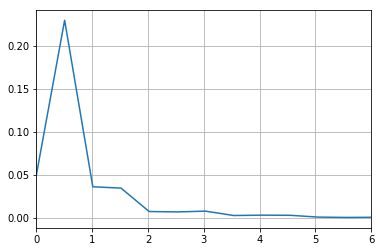

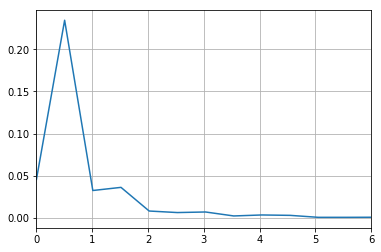

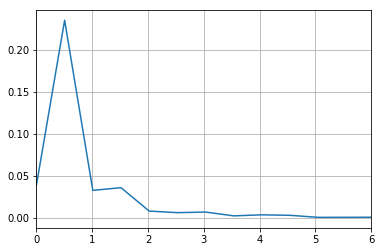

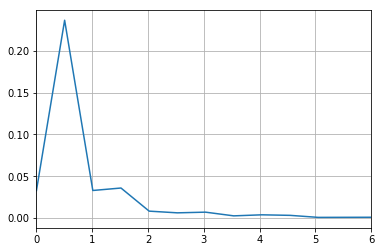

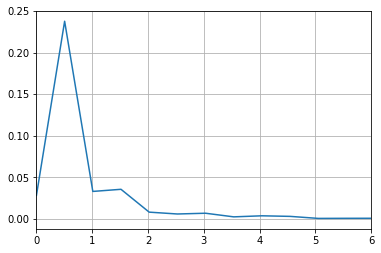

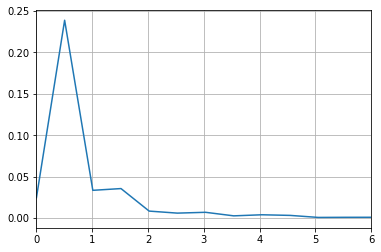

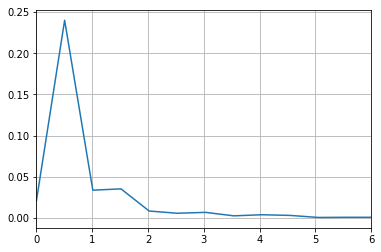

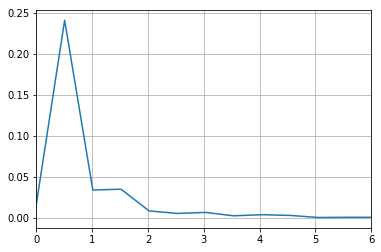

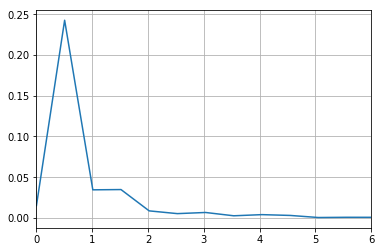

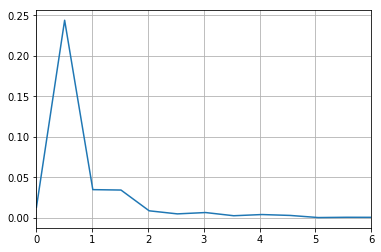

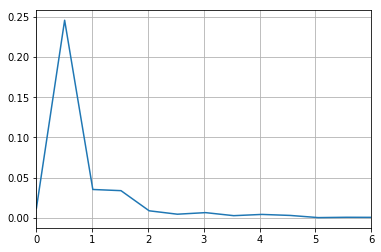

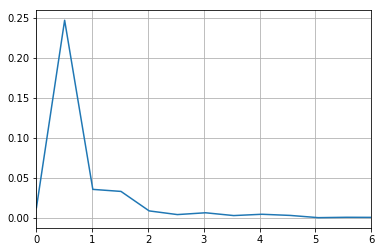

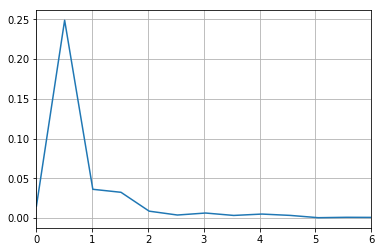

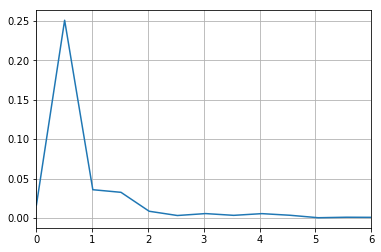

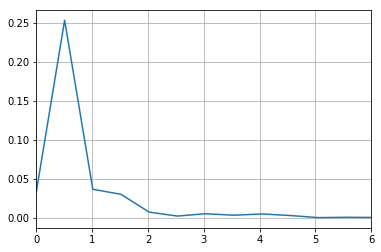

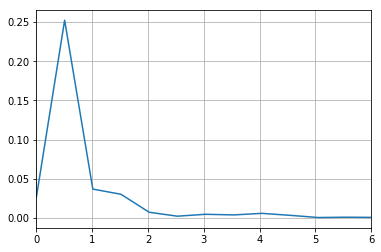

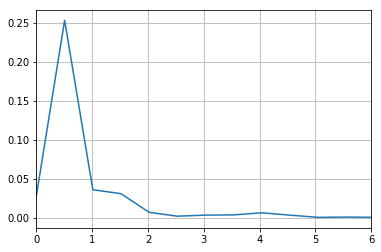

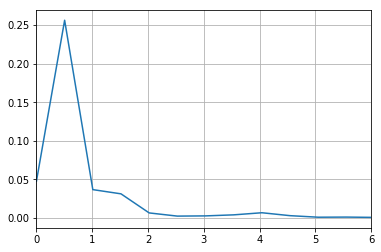

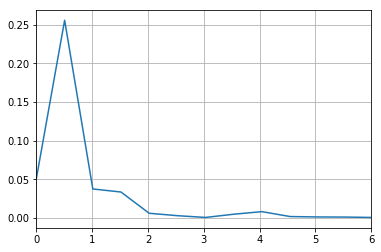

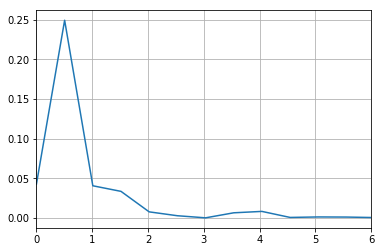

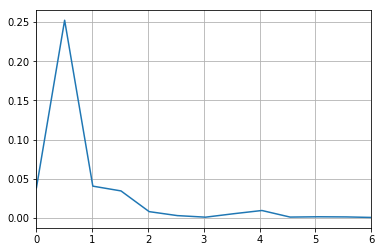

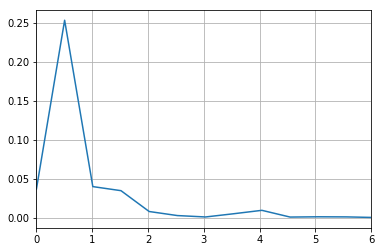

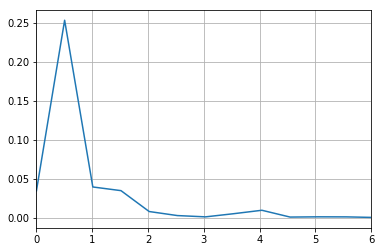

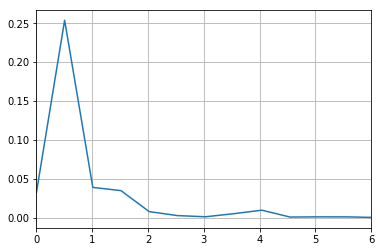

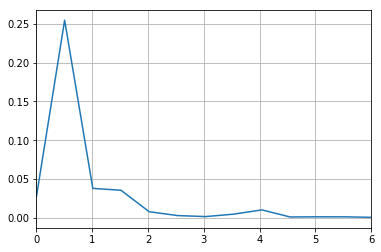

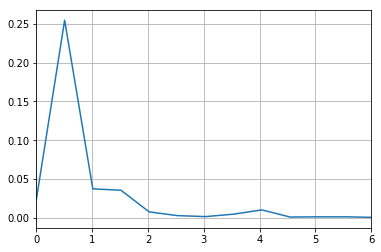

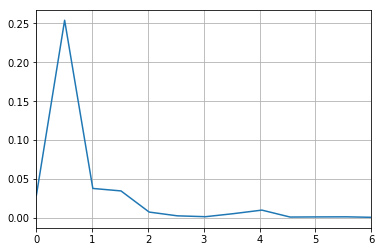

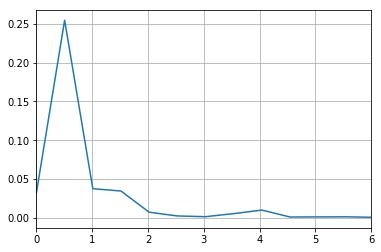

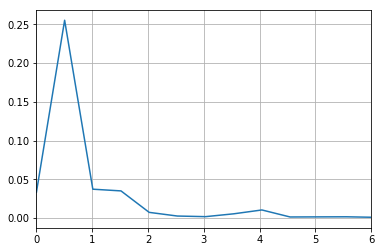

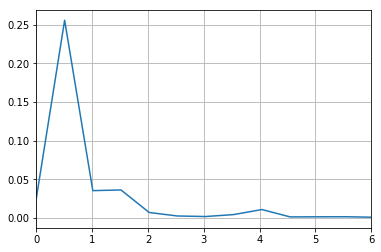

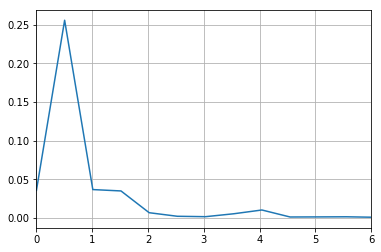

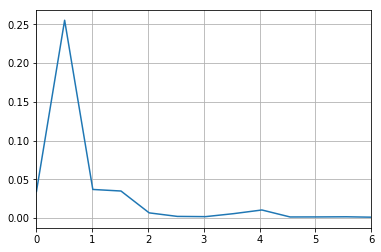

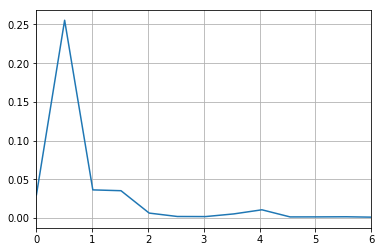

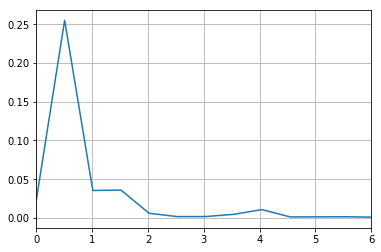

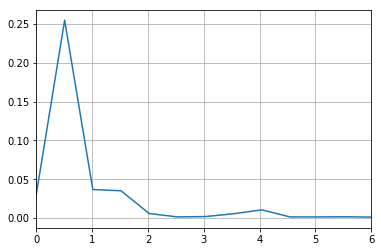

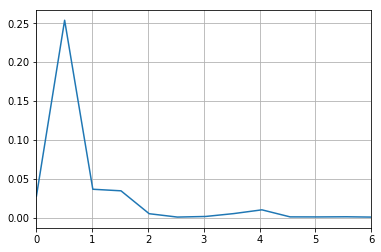

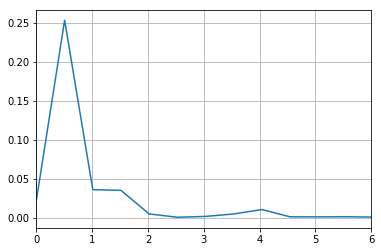

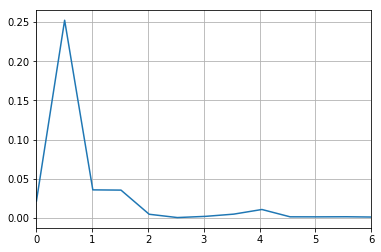

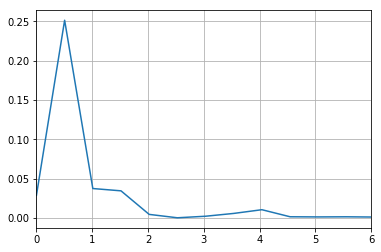

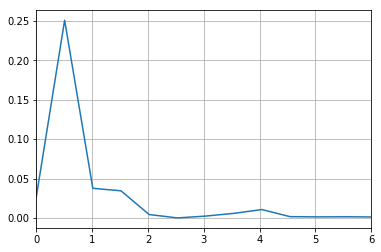

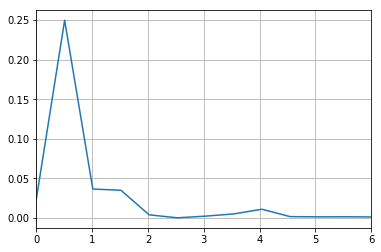

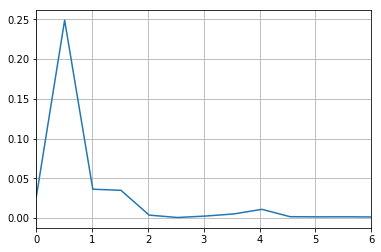

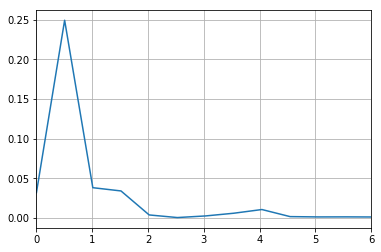

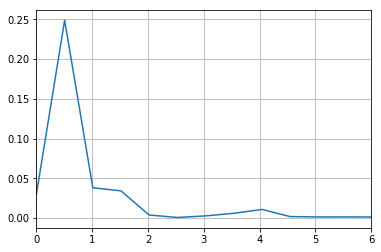

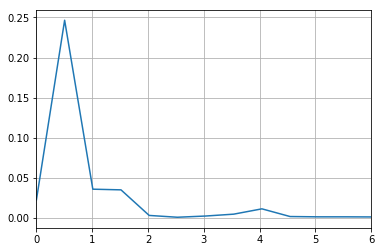

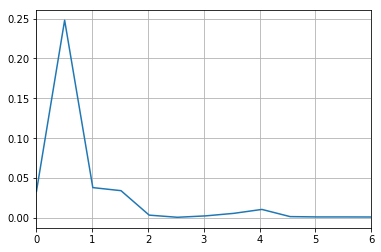

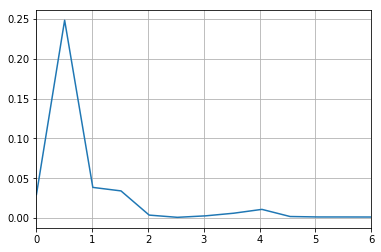

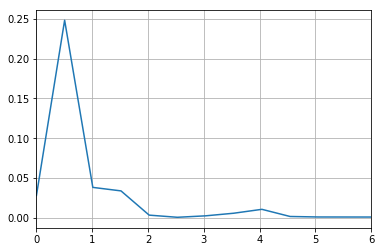

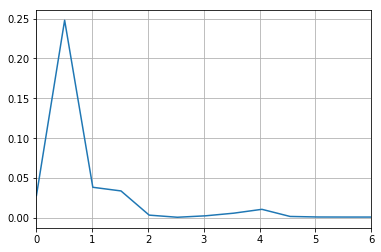

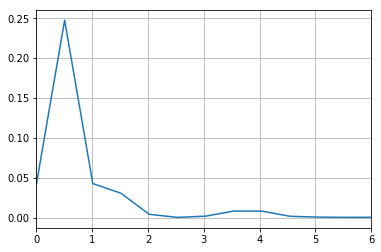

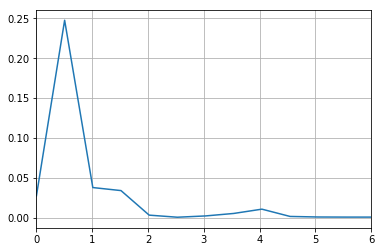

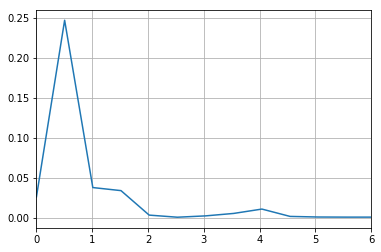

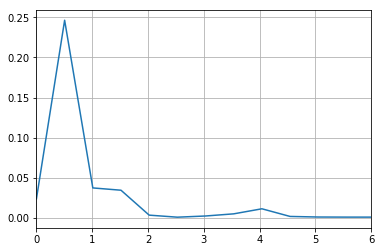

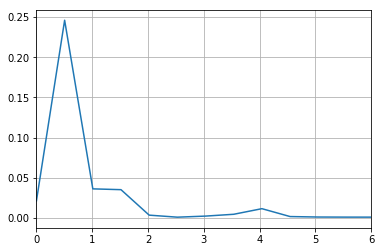

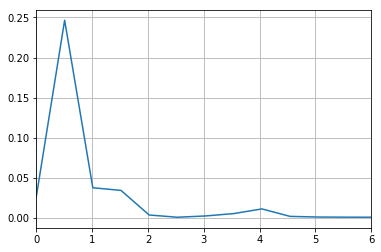

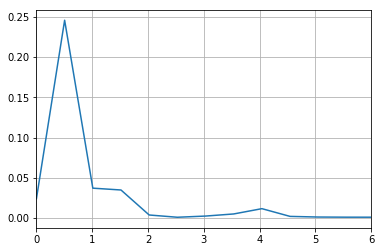

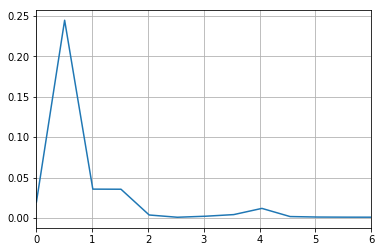

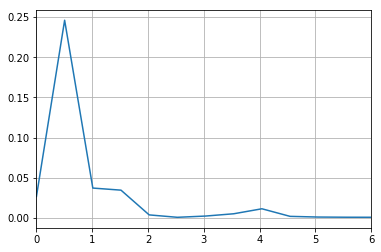

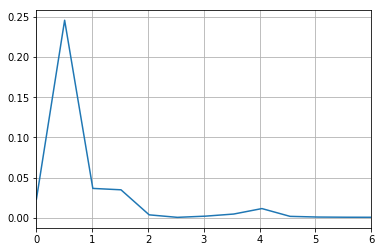

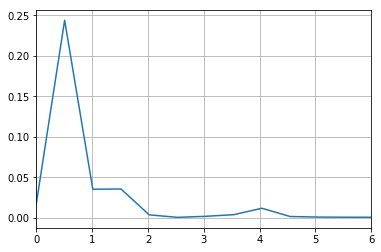

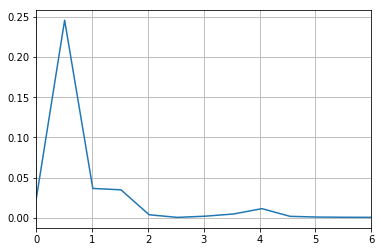

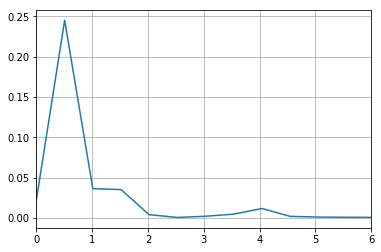

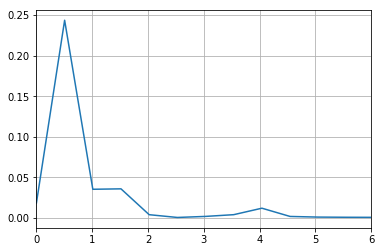

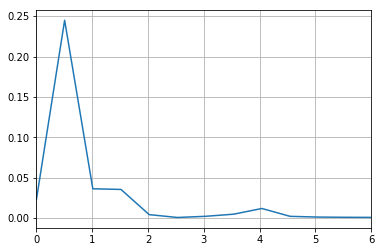

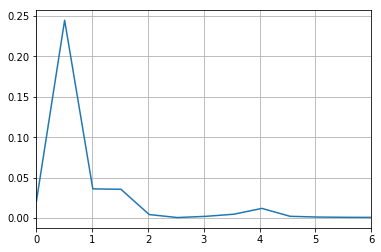

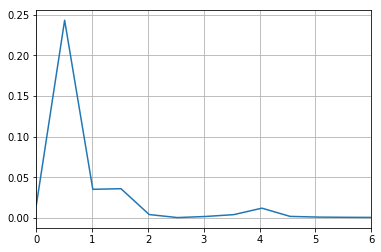

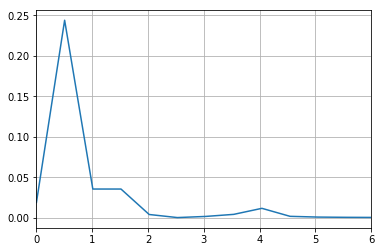

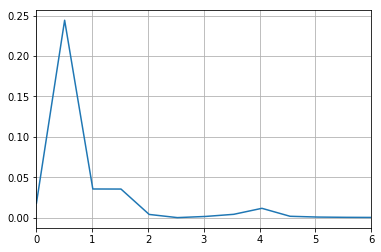

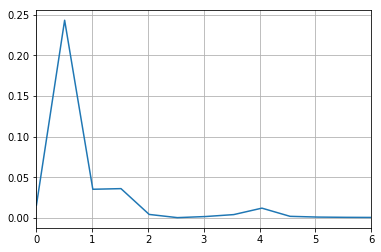

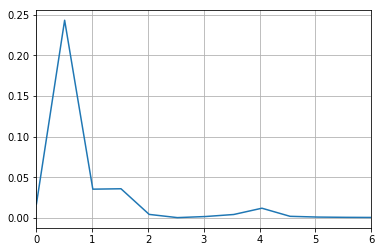

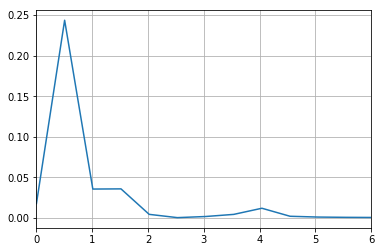

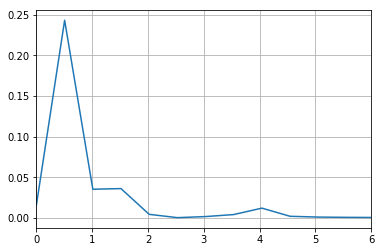

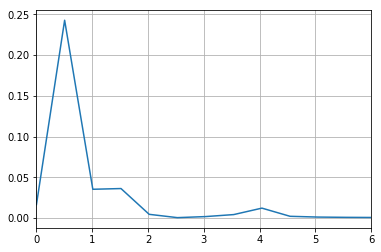

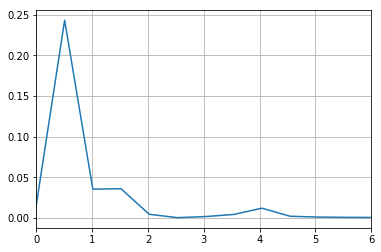

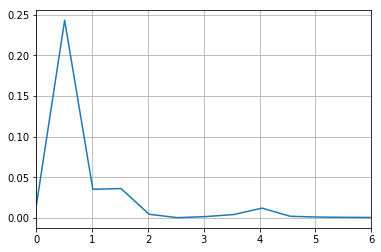

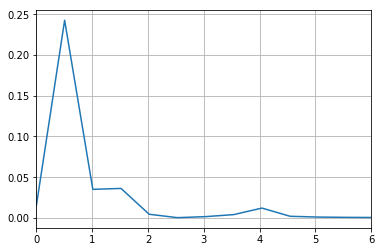

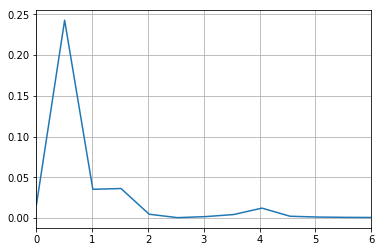

In [5]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss = train_on_batch(source_data)
    if epoch % 10 == 0:
#         plt.figure()
        res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
#         plt.plot(x_space, res)
#         plt.show()
        N = 200
        # sample spacing
        T = 1.0 / 100.0
        yf = fft(res)
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid()
        plt.xlim(0,6)
#         plt.ylim(0,0.04)
#         plt.show()        

#         print("Epoch #%d, Loss %.6f, Time %.2f sec" % (epoch, loss, time.time() - start))
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
        
        
        

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
anim_file = 'dcgan.gif'


In [0]:
import imageio
import glob
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


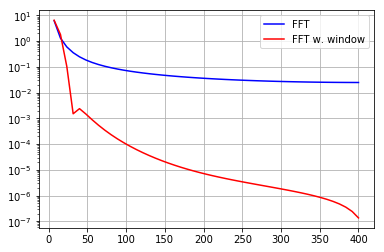

In [8]:

# from scipy.fftpack import fft
# # Number of sample points
# N = 200
# # sample spacing
# T = 1.0 / 100.0
# x = np.linspace(0.0, N*T, N)
# y = sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)
# yf = fft(res)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
# import matplotlib.pyplot as plt
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.grid()
# plt.xlim(0,15)
# plt.show()

from scipy.fftpack import fft
# Number of sample points
N = 100
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4 * np.sin(4*x) - 8 * np.sin(8*x) + 16 * np.sin(24*x)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(-1, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

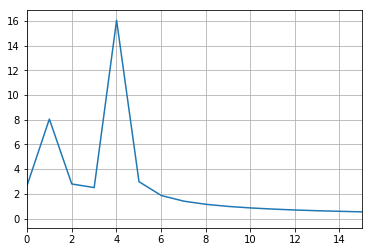

In [9]:
from scipy.fftpack import fft
# Number of sample points
N = 500
# sample spacing
T = 1.0 / 500.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4*np.sin(4*x) -8*np.sin(8*x) + 16*np.sin(24*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlim(0,15)
plt.show()

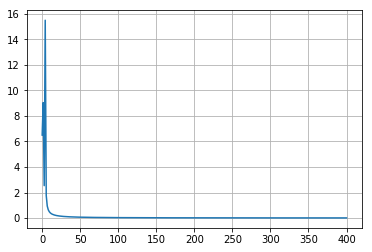

In [10]:
from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(x) + 4*np.sin(4*x) -8*np.sin(8*x) + 16*np.sin(24*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()